In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from datetime import timedelta
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [43]:
class dataset():
    def __init__(self, DataToExplain, ExplainingData1, ExplainingData2 ):
        self.DataToExplain = DataToExplain
        self.ExplainingData1 = ExplainingData1
        self.ExplainingData2 = ExplainingData2
        
        
    
    def preprocess_last2years_DataToExplain(self):
        
        self.DataToExplain.iloc[:,3] = self.DataToExplain.iloc[:,3].astype('datetime64[ns]')
#        data1.tail()
        self.DataToExplain.columns = ['n1','n2', 'OurPrice', 'Date']
        VA = pd.DataFrame(self.DataToExplain,columns= ['Date','OurPrice'])
        VAdate = VA.iloc[:,0]
        indices = list(VAdate[( VAdate < "2021-03-31") &  (VAdate > "2019-03-30")].index)
        VA = VA.iloc[indices,:]
        VA.reset_index(drop=True, inplace=True)
        return (VA)
    
    def preprocess_last2years_ExplainingData1(self):

        rng0 = range(0, len(data2.columns), 2)
        for i in rng0:
            self.ExplainingData1.iloc[:,i] = pd.to_datetime(self.ExplainingData1.iloc[:,i], format='%d/%m/%Y').dt.date
            self.ExplainingData1.iloc[:,i] = self.ExplainingData1.iloc[:,i].astype('datetime64[ns]')
        
        rng1 = range(1, len(self.ExplainingData1.columns)+1, 2)
        nb_col = len(self.ExplainingData1.columns)//2
        columns= list(self.ExplainingData1.columns[rng1])
    
        data2years= list()
    
        datatime = self.ExplainingData1.iloc[:,0]
        datelist = list(datatime[( datatime < "2021-03-31") &  (datatime > "2019-03-30")])
    
        data2years.append(datelist)
    
        columns_new= ["Date"]
        for i in range(nb_col):
            data = self.ExplainingData1.iloc[:,2*i]
            indices = list(data[( data < "2021-03-31") &  (data > "2019-03-30")].index)
            L = list(self.ExplainingData1.iloc[indices,2*i+1])
            if len(L) == len(datelist):
                data2years.append(L)
                columns_new.append(columns[i])
            
        data2years = np.array(data2years)
#        data2years.shape
        data2years = pd.DataFrame(data2years)
        data2years = data2years.transpose()
        data2years.columns = columns_new
        
        return(data2years)
    
    def preprocess_last2years_ExplainingData2(self):
        self.ExplainingData2.iloc[:,2] = pd.to_datetime(self.ExplainingData2.iloc[:,2], format='%d/%m/%Y').dt.date
        self.ExplainingData2.iloc[:,2] = self.ExplainingData2.iloc[:,2].astype('datetime64[ns]')
        
        self.ExplainingData2.columns = ['num', 'Explaining_Price' ,'Date']
        new_data = pd.DataFrame(self.ExplainingData2,columns= ['Date','Explaining_Price'])

        indices = list(new_data['Date'][(new_data['Date']< "2021-03-31") &  (new_data['Date'] > "2019-03-30")].index)
        new_data = new_data.iloc[indices,:]
        new_data.reset_index(drop=True, inplace=True)
        return(new_data)


    
    
    
    
    
    
    
    
    def preprocess_first2years_DataToExplain(self):
        
        self.DataToExplain.iloc[:,3] = self.DataToExplain.iloc[:,3].astype('datetime64[ns]')
#        data1.tail()
        self.DataToExplain.columns = ['n1','n2', 'OurPrice', 'Date']
        VA = pd.DataFrame(self.DataToExplain,columns= ['Date','OurPrice'])
        VAdate = VA.iloc[:,0]
        indices = list(VAdate[( VAdate < "2008-06-21") &  (VAdate > "2006-06-21")].index)
        VA = VA.iloc[indices,:]
        VA.reset_index(drop=True, inplace=True)
        return (VA)
    
    def preprocess_first2years_ExplainingData1(self):

        rng0 = range(0, len(data2.columns), 2)
        for i in rng0:
            self.ExplainingData1.iloc[:,i] = pd.to_datetime(self.ExplainingData1.iloc[:,i], format='%d/%m/%Y').dt.date
            self.ExplainingData1.iloc[:,i] = self.ExplainingData1.iloc[:,i].astype('datetime64[ns]')
        
        rng1 = range(1, len(self.ExplainingData1.columns)+1, 2)
        nb_col = len(self.ExplainingData1.columns)//2
        columns= list(self.ExplainingData1.columns[rng1])
    
        data2years= list()
    
        datatime = self.ExplainingData1.iloc[:,0]
        datelist = list(datatime[( datatime < "2008-06-21") &  (datatime > "2006-06-21")])
    
        data2years.append(datelist)
    
        columns_new= ["Date"]
        for i in range(nb_col):
            data = self.ExplainingData1.iloc[:,2*i]
            indices = list(data[( data < "2008-06-21") &  (data > "2006-06-21")].index)
            L = list(self.ExplainingData1.iloc[indices,2*i+1])
            if len(L) == len(datelist):
                data2years.append(L)
                columns_new.append(columns[i])
            
        data2years = np.array(data2years)
#        data2years.shape
        data2years = pd.DataFrame(data2years)
        data2years = data2years.transpose()
        data2years.columns = columns_new
        
        return(data2years)
    
    def preprocess_first2years_ExplainingData2(self):
        self.ExplainingData2.iloc[:,2] = pd.to_datetime(self.ExplainingData2.iloc[:,2], format='%d/%m/%Y').dt.date
        self.ExplainingData2.iloc[:,2] = self.ExplainingData2.iloc[:,2].astype('datetime64[ns]')
        
        self.ExplainingData2.columns = ['num', 'Explaining_Price' ,'Date']
        new_data = pd.DataFrame(self.ExplainingData2,columns= ['Date','Explaining_Price'])

        indices = list(new_data['Date'][(new_data['Date']< "2008-06-21") &  (new_data['Date'] > "2006-06-21")].index)
        new_data = new_data.iloc[indices,:]
        new_data.reset_index(drop=True, inplace=True)
        return(new_data)
    
    
    
    
    
    
    
    
    
    
    
    
    
    def export_ExplainingData1(self,path):
        self.preprocess_ExplainingData1().to_csv (path, sep= ';', index = False, header=True)
    
    def export_ExplainingData1(self,path):
        self.preprocess_ExplainingData2().to_csv (path, sep= ';', index = False, header=True)
    

    def DataTwoLastYears(self):
        DataToExplain= self.preprocess_last2years_DataToExplain()
        ExplainingData1 = self.preprocess_last2years_ExplainingData1()
        ExplainingData2 = self.preprocess_last2years_ExplainingData2()
        ExplainingData = ExplainingData1.join(ExplainingData2.set_index('Date'), on='Date')
        TwoYearsdata = ExplainingData.join( DataToExplain.set_index('Date'), on='Date')
        TwoYearsdata = TwoYearsdata.fillna(TwoYearsdata.mean())
        return(TwoYearsdata)
    
    def DataTwoFirstYears(self):
        DataToExplain= self.preprocess_first2years_DataToExplain()
        ExplainingData1 = self.preprocess_first2years_ExplainingData1()
        ExplainingData2 = self.preprocess_first2years_ExplainingData2()
        ExplainingData = ExplainingData1.join(ExplainingData2.set_index('Date'), on='Date')
        TwoYearsdata = ExplainingData.join( DataToExplain.set_index('Date'), on='Date')
        TwoYearsdata = TwoYearsdata.fillna(TwoYearsdata.mean())
        return(TwoYearsdata)

    def AnalyseAcp(self, data, n_comp = 3, name='OurPrice'):
        data_pca = data.iloc[:,1:-1]
        features = data.iloc[:,1:].columns

        # Do the PCA.
        n_components=3
        pca = PCA(n_components=n_components)
        reduced = pca.fit_transform(data_pca)

        # Append the principle components for each entry to the dataframe
        for i in range(0, n_components):
            data_pca['PC' + str(i + 1)] = reduced[:, i]
        display(data_pca.head())

        # Do a scree plot
        ind = np.arange(0, n_components)
        (fig, ax) = plt.subplots(figsize=(8, 6))
        sns.pointplot(x=ind, y=pca.explained_variance_ratio_)
        ax.set_title('Scree plot')
        ax.set_xticks(ind)
        ax.set_xticklabels(ind)
        ax.set_xlabel('Component Number')
        ax.set_ylabel('Explained Variance')
        plt.show()

        # Show the points in terms of the first two PCs
        g = sns.lmplot('PC1',
                       'PC2',data=data_pca,
                       fit_reg=False,
                       scatter=True,
                       size=7)

        plt.show()

        # Plot a variable factor map for the first two dimensions.
        (fig, ax) = plt.subplots(figsize=(8, 8))
        for i in range(0, pca.components_.shape[1]):
            if (data_pca.columns.values[i] == name):
                ax.arrow(0,
                        0,  # Start the arrow at the origin
                        pca.components_[0, i],  #0 for PC1
                        pca.components_[1, i],  #1 for PC2
                        head_width=0.01,
                        head_length=0.01,
                        color ='r')
            else: 
                ax.arrow(0,
                        0,  # Start the arrow at the origin
                        pca.components_[0, i],  #0 for PC1
                        pca.components_[1, i],  #1 for PC2
                        head_width=0.01,
                        head_length=0.01)
                        
        #    plt.text(pca.components_[0, i] + 0.05,
        #             pca.components_[1, i] + 0.05,
        #             data_pca.columns.values[i])


        an = np.linspace(0, 2 * np.pi, 100)
        plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
        plt.axis('equal')
        ax.set_title('Variable factor map')
        plt.show()

        return reduced

    

In [28]:
data1 = pd.read_csv("VariableAexpliquer.csv", header=None, sep=',')
data2 = pd.read_csv("VariableExplicative1.csv", header=0 , sep=';')
data3 = pd.read_csv("VariableExplicative2.csv", header=None, sep=';')

data1.head()

C:\Users\Younes\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,2,4,6,8,10,12,14,16,18,20,22,24,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64,66,68,70,72,74,76,78,80,82,84,86,88,90,92,94,96,98,100,102,104,106,108,110,112,114,116,118,120,122,124,126,128,130,132,134,136,138,140,142,144,146,148,150,152,154,156,158,166,168,170,172,174,176,178,180,182,184,186,188,190,192,194,196,198,200,202,204,206,208,210,212,214,216,218,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,274,276,278,280,282,284,286,288,290,292,294,296,298,300,302,304) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3
0,8920837,47762,100.00,2006-06-21
1,8920838,47762,99.84,2006-06-22
2,8920839,47762,100.16,2006-06-26
3,8920840,47762,98.70,2006-06-27
4,8920841,47762,99.42,2006-06-28


In [6]:
data2.head()

,date_EMU Equity Mid-Cap,prices_EMU Equity Mid-Cap,date_EMU Equity Mix-Cap,prices_EMU Equity Mix-Cap,date_EMU Equity Small-Cap,prices_EMU Equity Small-Cap,date_EMU Equity Small-Cap Growth,prices_EMU Equity Small-Cap Growth,date_EMU Equity Large-Mid-Cap Growth,prices_EMU Equity Large-Mid-Cap Growth,...,date_Asia Pacific ExJapan Equity Mix-Cap,prices_Asia Pacific ExJapan Equity Mix-Cap,date_Asia Pacific ExJapan Equity Mix-Cap Growth,prices_Asia Pacific ExJapan Equity Mix-Cap Growth,date_Asia Pacific ExJapan Equity Mix-Cap Value,prices_Asia Pacific ExJapan Equity Mix-Cap Value,date_Asia ExJapan Equity Mix-Cap Low Vol & Income,prices_Asia ExJapan Equity Mix-Cap Low Vol & Income,date_Asia Pacific ExJapan Equity Mix-Cap Low Vol & Income,prices_Asia Pacific ExJapan Equity Mix-Cap Low Vol & Income
0,18/10/1999,100.000000,11/06/1996,100.000000,13/04/1995,100.000000,24/03/1994,100.000000,01/06/1992,100.000000,...,30/11/1990,100.000000,29/03/1985,100.000000,16/08/1996,100.000000,15/02/2000,100.000000,01/02/1991,100.000000
1,19/10/1999,100.147586,12/06/1996,99.989838,14/04/1995,100.392491,25/03/1994,99.900894,02/06/1992,100.049205,...,03/12/1990,99.581829,01/04/1985,99.088661,19/08/1996,100.339824,16/02/2000,100.647902,04/02/1991,101.311334
2,20/10/1999,100.170269,13/06/1996,100.100615,17/04/1995,100.392491,28/03/1994,100.079900,03/06/1992,99.806687,...,04/12/1990,99.877288,02/04/1985,99.092974,20/08/1996,100.341970,17/02/2000,100.671600,05/02/1991,102.867164
3,21/10/1999,100.209249,14/06/1996,100.100615,18/04/1995,99.953732,29/03/1994,99.876355,04/06/1992,99.788866,...,05/12/1990,100.212559,03/04/1985,98.535761,21/08/1996,101.537387,18/02/2000,99.012812,06/02/1991,103.752418
4,22/10/1999,100.753414,17/06/1996,100.100615,19/04/1995,99.497032,30/03/1994,100.031413,05/06/1992,99.753832,...,06/12/1990,101.183295,04/04/1985,96.984054,22/08/1996,101.343077,21/02/2000,97.658367,07/02/1991,104.692907


In [7]:
data3.head()

,0,1,2
0,25,0.002778,01/01/1960
1,25,0.002778,02/01/1960
2,25,0.002778,03/01/1960
3,25,0.002778,04/01/1960
4,25,0.002778,05/01/1960


In [44]:
d = dataset(data1,data2,data3)
d.DataToExplain

,n1,n2,OurPrice,Date
0,8920837,47762,100.000000,2006-06-21
1,8920838,47762,99.840000,2006-06-22
2,8920839,47762,100.160000,2006-06-26
3,8920840,47762,98.700000,2006-06-27
4,8920841,47762,99.420000,2006-06-28
...,...,...,...,...
3593,37413153,47762,272.145100,2021-03-22
3594,37413154,47762,268.853627,2021-03-23
3595,37413155,47762,265.662235,2021-03-24
3596,37413156,47762,267.170756,2021-03-25


In [30]:
L2YDataToExplain= d.preprocess_last2years_DataToExplain()
L2YDataToExplain

,Date,OurPrice
0,2019-04-01,211.770000
1,2019-04-02,212.000000
2,2019-04-03,212.990000
3,2019-04-04,212.920000
4,2019-04-05,213.680000
...,...,...
473,2021-03-22,272.145100
474,2021-03-23,268.853627
475,2021-03-24,265.662235
476,2021-03-25,267.170756


In [31]:
L2YExplainingData2 = d.preprocess_last2years_ExplainingData2()
L2YExplainingData2

,Date,Explaining_Price
0,2019-03-31,0.009028
1,2019-04-01,0.009012
2,2019-04-02,0.008979
3,2019-04-03,0.008973
4,2019-04-05,0.008955
...,...,...
668,2021-02-02,0.009524
669,2021-02-03,0.009518
670,2021-02-04,0.009503
671,2021-02-05,0.009456


In [32]:
 L2YExplainingData1 = d.preprocess_last2years_ExplainingData1()
 L2YExplainingData1

,Date,prices_EMU Equity Mid-Cap,prices_EMU Equity Mix-Cap,prices_EMU Equity Small-Cap,prices_EMU Equity Small-Cap Growth,prices_EMU Equity Large-Mid-Cap Growth,prices_EMU Equity Large-Mid-Cap Quality,prices_EMU Equity Large-Mid-Cap Multi Factors,prices_EMU Equity Large-Mid-Cap Value,prices_EMU Equity Large-Mid-Cap Low volatility,...,prices_Metals & Mining Equity,prices_ASEAN Equity Mix-Cap,prices_Asia ExJapan Equity Mix-Cap,prices_Asia ExJapan Equity Mix-Cap Growth,prices_Asia ExJapan Equity Small-Mid-cap,prices_Asia Pacific ExJapan Equity Mix-Cap,prices_Asia Pacific ExJapan Equity Mix-Cap Growth,prices_Asia Pacific ExJapan Equity Mix-Cap Value,prices_Asia ExJapan Equity Mix-Cap Low Vol & Income,prices_Asia Pacific ExJapan Equity Mix-Cap Low Vol & Income
0,2019-04-01,440.74,733.14,445.679,1405.45,645.043,301.415,156.82,602.974,401.333,...,1228.42,267.961,4910.45,1374.17,1647.68,2126.53,8295.05,597.139,476.885,1413.66
1,2019-04-02,442.17,736.059,447.68,1411.45,647.155,302.54,157.415,606.061,402.797,...,1217.64,268.984,4923.78,1377.97,1652.14,2129.19,8293.98,600.681,477.459,1415.4
2,2019-04-03,446.92,744.218,452.811,1428.87,654.061,305.578,159.047,613.575,406.238,...,1222.33,270.526,4963.97,1390.12,1656.83,2149.74,8373.55,606.383,479.57,1425.98
3,2019-04-04,445.205,743.55,452.644,1426.7,654.314,305.933,158.959,614.585,406.298,...,1228.19,270.539,4963.64,1389.39,1655.66,2148,8372.82,607.003,479.67,1423.16
4,2019-04-05,445.674,745.037,453.881,1432.68,655.262,306.009,159.255,615.628,406.799,...,1235.8,270.832,4972.41,1392.16,1659.5,2147.05,8378.77,606.676,480.265,1420.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,2021-03-24,586.976,852.637,587.945,1818.84,786.876,365.376,180.034,734.076,449.875,...,2438.82,298.347,7073.53,1992.18,2203.01,2953.56,11003.5,768.683,644.268,1737.24
518,2021-03-25,584.952,851.742,586.645,1815.84,787.042,365.363,180.144,733.757,450.698,...,2423.46,298.182,7032.75,1979.36,2201.06,2942.44,10941.2,762.762,640.337,1734.35
519,2021-03-26,590.399,860.295,592.251,1832.32,793.436,368.138,181.644,740.973,453.804,...,2438.51,299.604,7099.22,2001.12,2224.3,2962.08,11000.2,768.174,649.205,1741.39
520,2021-03-29,590.613,855.76,597.021,1834.84,800.124,369.028,181.644,745.615,454.879,...,2468.16,301.886,7114.43,1992.53,2224.3,2965.85,11070.5,766.122,655.27,1748.81


In [34]:
# d1.set_index('Date').join(d2.set_index('Date'))
# ExplainingData = ExplainingData1.join(ExplainingData2.set_index('Date'), on='Date')
# TwoYearsdata = ExplainingData.join( DataToExplain.set_index('Date'), on='Date')
# TwoYearsdata = TwoYearsdata.fillna(TwoYearsdata.mean())

L2Ydata = d.DataTwoLastYears()
L2Ydata

,Date,prices_EMU Equity Mid-Cap,prices_EMU Equity Mix-Cap,prices_EMU Equity Small-Cap,prices_EMU Equity Small-Cap Growth,prices_EMU Equity Large-Mid-Cap Growth,prices_EMU Equity Large-Mid-Cap Quality,prices_EMU Equity Large-Mid-Cap Multi Factors,prices_EMU Equity Large-Mid-Cap Value,prices_EMU Equity Large-Mid-Cap Low volatility,...,prices_Asia ExJapan Equity Mix-Cap,prices_Asia ExJapan Equity Mix-Cap Growth,prices_Asia ExJapan Equity Small-Mid-cap,prices_Asia Pacific ExJapan Equity Mix-Cap,prices_Asia Pacific ExJapan Equity Mix-Cap Growth,prices_Asia Pacific ExJapan Equity Mix-Cap Value,prices_Asia ExJapan Equity Mix-Cap Low Vol & Income,prices_Asia Pacific ExJapan Equity Mix-Cap Low Vol & Income,Explaining_Price,OurPrice
0,2019-04-01,440.74,733.14,445.679,1405.45,645.043,301.415,156.82,602.974,401.333,...,4910.45,1374.17,1647.68,2126.53,8295.05,597.139,476.885,1413.66,0.009012,211.770000
1,2019-04-02,442.17,736.059,447.68,1411.45,647.155,302.54,157.415,606.061,402.797,...,4923.78,1377.97,1652.14,2129.19,8293.98,600.681,477.459,1415.4,0.008979,212.000000
2,2019-04-03,446.92,744.218,452.811,1428.87,654.061,305.578,159.047,613.575,406.238,...,4963.97,1390.12,1656.83,2149.74,8373.55,606.383,479.57,1425.98,0.008973,212.990000
3,2019-04-04,445.205,743.55,452.644,1426.7,654.314,305.933,158.959,614.585,406.298,...,4963.64,1389.39,1655.66,2148,8372.82,607.003,479.67,1423.16,0.009319,212.920000
4,2019-04-05,445.674,745.037,453.881,1432.68,655.262,306.009,159.255,615.628,406.799,...,4972.41,1392.16,1659.5,2147.05,8378.77,606.676,480.265,1420.99,0.008955,213.680000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,2021-03-24,586.976,852.637,587.945,1818.84,786.876,365.376,180.034,734.076,449.875,...,7073.53,1992.18,2203.01,2953.56,11003.5,768.683,644.268,1737.24,0.009319,265.662235
518,2021-03-25,584.952,851.742,586.645,1815.84,787.042,365.363,180.144,733.757,450.698,...,7032.75,1979.36,2201.06,2942.44,10941.2,762.762,640.337,1734.35,0.009319,267.170756
519,2021-03-26,590.399,860.295,592.251,1832.32,793.436,368.138,181.644,740.973,453.804,...,7099.22,2001.12,2224.3,2962.08,11000.2,768.174,649.205,1741.39,0.009319,271.194761
520,2021-03-29,590.613,855.76,597.021,1834.84,800.124,369.028,181.644,745.615,454.879,...,7114.43,1992.53,2224.3,2965.85,11070.5,766.122,655.27,1748.81,0.009319,218.777981


In [49]:
L2Ydata.to_csv ('L2Ydata.csv', sep= ';', index = False, header=True)


In [42]:
F2YDataToExplain= d.preprocess_first2years_DataToExplain()
F2YDataToExplain

,Date,OurPrice
0,2006-06-22,99.84
1,2006-06-26,100.16
2,2006-06-27,98.70
3,2006-06-28,99.42
4,2006-06-29,102.03
...,...,...
487,2008-06-16,122.14
488,2008-06-17,121.93
489,2008-06-18,120.63
490,2008-06-19,120.10


In [41]:
F2YExplainingData2 = d.preprocess_first2years_ExplainingData2()
F2YExplainingData2

,Date,Explaining_Price
0,2006-06-22,0.008649
1,2006-06-23,0.008592
2,2006-06-24,0.008592
3,2006-06-25,0.008592
4,2006-06-27,0.008583
...,...,...
676,2008-06-16,0.009242
677,2008-06-17,0.009235
678,2008-06-18,0.009243
679,2008-06-19,0.009273


In [40]:
 F2YExplainingData1 = d.preprocess_first2years_ExplainingData1()
 F2YExplainingData1

,Date,prices_EMU Equity Mid-Cap,prices_EMU Equity Mix-Cap,prices_EMU Equity Small-Cap,prices_EMU Equity Small-Cap Growth,prices_EMU Equity Large-Mid-Cap Growth,prices_EMU Equity Large-Mid-Cap Quality,prices_EMU Equity Large-Mid-Cap Value,prices_EMU Equity Large-Mid-Cap Low volatility,prices_EMU Equity Large-Mid-Cap Income,...,prices_Utilities Equity,prices_Metals & Mining Equity,prices_Asia ExJapan Equity Mix-Cap,prices_Asia ExJapan Equity Mix-Cap Growth,prices_Asia ExJapan Equity Small-Mid-cap,prices_Asia Pacific ExJapan Equity Mix-Cap,prices_Asia Pacific ExJapan Equity Mix-Cap Growth,prices_Asia Pacific ExJapan Equity Mix-Cap Value,prices_Asia ExJapan Equity Mix-Cap Low Vol & Income,prices_Asia Pacific ExJapan Equity Mix-Cap Low Vol & Income
0,2006-06-22,245.93,368.292,171.853,458.603,320.215,171.876,344.713,178.037,234.623,...,215.266,824.553,1557.08,358.941,422.349,620.586,2320.52,193.12,191.458,471.036
1,2006-06-23,245.565,369.184,172.171,460.46,321.128,172.079,345.462,177.975,235.137,...,214.389,825.195,1550.79,357.826,422.101,616.085,2322.53,191.282,193.742,467.161
2,2006-06-26,245.739,368.836,172.715,462.612,321.148,171.956,345.405,178.205,234.966,...,214.358,834.55,1552.78,359.482,422.352,617.767,2323.69,191.498,193.711,466.645
3,2006-06-27,244.802,366.883,172.376,462.147,319.367,170.677,343.766,178.811,234.138,...,214.716,830.525,1562.35,360.859,424.827,621.831,2331.86,192.406,194.98,468.207
4,2006-06-28,244.437,366.405,171.348,459.597,318.471,170.418,342.95,179.465,233.419,...,215.156,818.801,1558.72,360.61,424.782,618.559,2322.57,192.801,194.19,467.008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,2008-06-16,231.323,380.673,179.231,487.344,327.579,180.139,368.331,218.448,246.006,...,339.596,1179.17,2422.7,626.179,581.649,1017.63,3605.14,314.743,294.988,665.502
518,2008-06-17,232.002,382.149,180.401,490.453,328.287,181.192,369.491,219.045,246.65,...,340.056,1188.42,2435.87,628.492,582.366,1023.45,3603.82,314.372,296.944,668.981
519,2008-06-18,226.966,378.031,178.313,482.895,325.179,178.423,365.08,215.756,243.695,...,339.796,1195.74,2443.83,632.02,582.613,1027.94,3639.9,313.813,298.613,669.247
520,2008-06-19,224.986,374.835,176.671,478.561,322.656,177.201,361.814,214.923,241.584,...,339.94,1198.59,2401.71,619.557,575.075,1014.43,3592.63,309.52,292.479,657.706


In [45]:
F2Ydata = d.DataTwoFirstYears()
F2Ydata

,Date,prices_EMU Equity Mid-Cap,prices_EMU Equity Mix-Cap,prices_EMU Equity Small-Cap,prices_EMU Equity Small-Cap Growth,prices_EMU Equity Large-Mid-Cap Growth,prices_EMU Equity Large-Mid-Cap Quality,prices_EMU Equity Large-Mid-Cap Value,prices_EMU Equity Large-Mid-Cap Low volatility,prices_EMU Equity Large-Mid-Cap Income,...,prices_Asia ExJapan Equity Mix-Cap,prices_Asia ExJapan Equity Mix-Cap Growth,prices_Asia ExJapan Equity Small-Mid-cap,prices_Asia Pacific ExJapan Equity Mix-Cap,prices_Asia Pacific ExJapan Equity Mix-Cap Growth,prices_Asia Pacific ExJapan Equity Mix-Cap Value,prices_Asia ExJapan Equity Mix-Cap Low Vol & Income,prices_Asia Pacific ExJapan Equity Mix-Cap Low Vol & Income,Explaining_Price,OurPrice
0,2006-06-22,245.93,368.292,171.853,458.603,320.215,171.876,344.713,178.037,234.623,...,1557.08,358.941,422.349,620.586,2320.52,193.12,191.458,471.036,0.008649,99.840000
1,2006-06-23,245.565,369.184,172.171,460.46,321.128,172.079,345.462,177.975,235.137,...,1550.79,357.826,422.101,616.085,2322.53,191.282,193.742,467.161,0.008592,123.812857
2,2006-06-26,245.739,368.836,172.715,462.612,321.148,171.956,345.405,178.205,234.966,...,1552.78,359.482,422.352,617.767,2323.69,191.498,193.711,466.645,0.008762,100.160000
3,2006-06-27,244.802,366.883,172.376,462.147,319.367,170.677,343.766,178.811,234.138,...,1562.35,360.859,424.827,621.831,2331.86,192.406,194.98,468.207,0.008583,98.700000
4,2006-06-28,244.437,366.405,171.348,459.597,318.471,170.418,342.95,179.465,233.419,...,1558.72,360.61,424.782,618.559,2322.57,192.801,194.19,467.008,0.008603,99.420000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,2008-06-16,231.323,380.673,179.231,487.344,327.579,180.139,368.331,218.448,246.006,...,2422.7,626.179,581.649,1017.63,3605.14,314.743,294.988,665.502,0.009242,122.140000
518,2008-06-17,232.002,382.149,180.401,490.453,328.287,181.192,369.491,219.045,246.65,...,2435.87,628.492,582.366,1023.45,3603.82,314.372,296.944,668.981,0.009235,121.930000
519,2008-06-18,226.966,378.031,178.313,482.895,325.179,178.423,365.08,215.756,243.695,...,2443.83,632.02,582.613,1027.94,3639.9,313.813,298.613,669.247,0.009243,120.630000
520,2008-06-19,224.986,374.835,176.671,478.561,322.656,177.201,361.814,214.923,241.584,...,2401.71,619.557,575.075,1014.43,3592.63,309.52,292.479,657.706,0.009273,120.100000


In [48]:
F2Ydata.to_csv ('F2Ydata.csv', sep= ';', index = False, header=True)


## ACP

,prices_EMU Equity Mid-Cap,prices_EMU Equity Mix-Cap,prices_EMU Equity Small-Cap,prices_EMU Equity Small-Cap Growth,prices_EMU Equity Large-Mid-Cap Growth,prices_EMU Equity Large-Mid-Cap Quality,prices_EMU Equity Large-Mid-Cap Multi Factors,prices_EMU Equity Large-Mid-Cap Value,prices_EMU Equity Large-Mid-Cap Low volatility,prices_EMU Equity Large-Mid-Cap Income,...,prices_Asia ExJapan Equity Small-Mid-cap,prices_Asia Pacific ExJapan Equity Mix-Cap,prices_Asia Pacific ExJapan Equity Mix-Cap Growth,prices_Asia Pacific ExJapan Equity Mix-Cap Value,prices_Asia ExJapan Equity Mix-Cap Low Vol & Income,prices_Asia Pacific ExJapan Equity Mix-Cap Low Vol & Income,Explaining_Price,PC1,PC2,PC3
0,440.74,733.14,445.679,1405.45,645.043,301.415,156.82,602.974,401.333,389.765,...,1647.68,2126.53,8295.05,597.139,476.885,1413.66,0.009012,1812.257244,-3143.789780,597.768698
1,442.17,736.059,447.68,1411.45,647.155,302.54,157.415,606.061,402.797,391.784,...,1652.14,2129.19,8293.98,600.681,477.459,1415.4,0.008979,1637.336108,-3187.151424,595.091777
2,446.92,744.218,452.811,1428.87,654.061,305.578,159.047,613.575,406.238,395.8,...,1656.83,2149.74,8373.55,606.383,479.57,1425.98,0.008973,1256.272393,-3217.296219,613.272834
3,445.205,743.55,452.644,1426.7,654.314,305.933,158.959,614.585,406.298,396.23,...,1655.66,2148,8372.82,607.003,479.67,1423.16,0.009319,1108.963601,-3270.809158,593.172294
4,445.674,745.037,453.881,1432.68,655.262,306.009,159.255,615.628,406.799,396.516,...,1659.5,2147.05,8378.77,606.676,480.265,1420.99,0.008955,860.478219,-3336.026650,581.608889


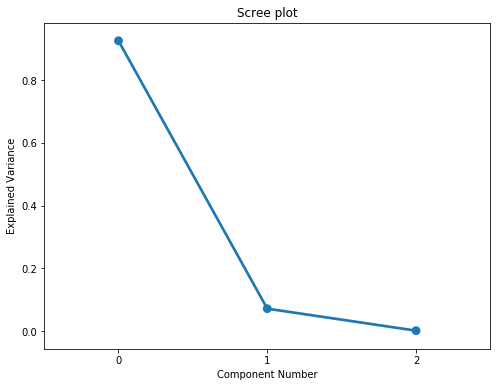

C:\Users\Younes\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


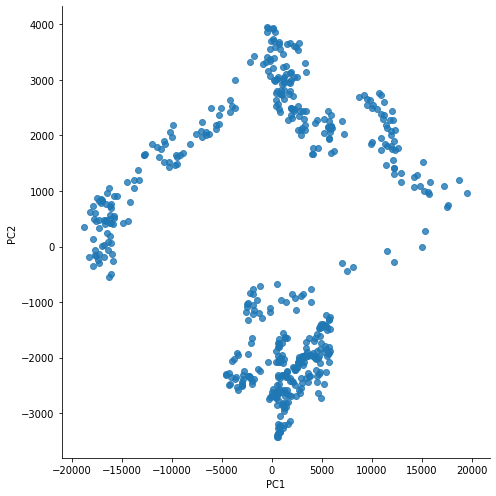

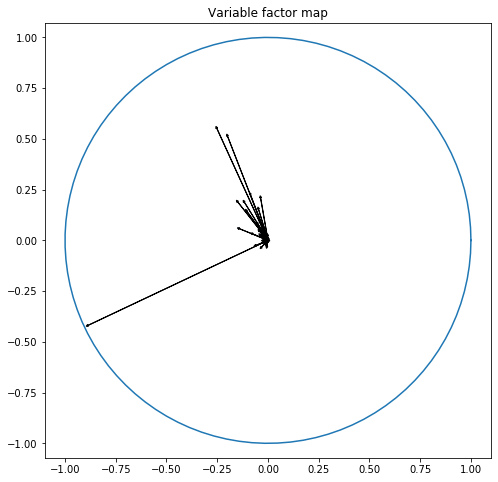

array([[  1812.25724385,  -3143.78977976,    597.76869758],
       [  1637.33610791,  -3187.15142378,    595.09177667],
       [  1256.27239251,  -3217.29621866,    613.27283436],
       ...,
       [-16759.42778122,     22.16030507,   -274.19900197],
       [-17251.06262051,    340.04643253,   -413.87771508],
       [-17886.43380895,    137.84045457,   -344.57802145]])

In [35]:
d.AnalyseAcp(L2Ydata,3,'OurPrice')

,prices_EMU Equity Mid-Cap,prices_EMU Equity Mix-Cap,prices_EMU Equity Small-Cap,prices_EMU Equity Small-Cap Growth,prices_EMU Equity Large-Mid-Cap Growth,prices_EMU Equity Large-Mid-Cap Quality,prices_EMU Equity Large-Mid-Cap Value,prices_EMU Equity Large-Mid-Cap Low volatility,prices_EMU Equity Large-Mid-Cap Income,prices_Global Equity Large-Cap,...,prices_Asia ExJapan Equity Small-Mid-cap,prices_Asia Pacific ExJapan Equity Mix-Cap,prices_Asia Pacific ExJapan Equity Mix-Cap Growth,prices_Asia Pacific ExJapan Equity Mix-Cap Value,prices_Asia ExJapan Equity Mix-Cap Low Vol & Income,prices_Asia Pacific ExJapan Equity Mix-Cap Low Vol & Income,Explaining_Price,PC1,PC2,PC3
0,245.93,368.292,171.853,458.603,320.215,171.876,344.713,178.037,234.623,904.163,...,422.349,620.586,2320.52,193.12,191.458,471.036,0.008649,10449.097715,466.245103,-115.456550
1,245.565,369.184,172.171,460.46,321.128,172.079,345.462,177.975,235.137,901.013,...,422.101,616.085,2322.53,191.282,193.742,467.161,0.008592,10518.334108,471.549263,-120.153585
2,245.739,368.836,172.715,462.612,321.148,171.956,345.405,178.205,234.966,902.123,...,422.352,617.767,2323.69,191.498,193.711,466.645,0.008762,10621.938216,447.343007,-120.318101
3,244.802,366.883,172.376,462.147,319.367,170.677,343.766,178.811,234.138,902.736,...,424.827,621.831,2331.86,192.406,194.98,468.207,0.008583,10505.269287,464.707329,-126.035329
4,244.437,366.405,171.348,459.597,318.471,170.418,342.95,179.465,233.419,901.021,...,424.782,618.559,2322.57,192.801,194.19,467.008,0.008603,10331.001398,503.223389,-115.315642


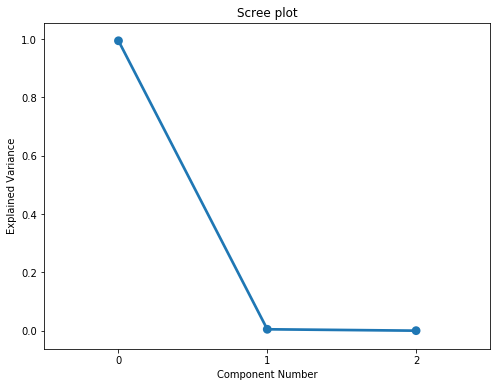

C:\Users\Younes\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


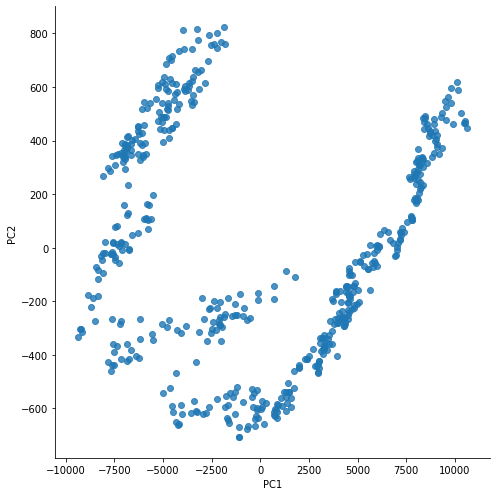

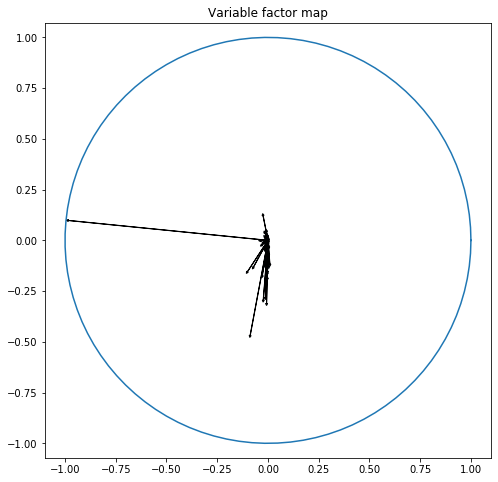

array([[10449.09771464,   466.24510304,  -115.45654968],
       [10518.33410782,   471.54926313,  -120.1535852 ],
       [10621.93821624,   447.34300714,  -120.3181014 ],
       ...,
       [-4985.19626678,   488.02351683,   276.37363806],
       [-4772.73861877,   518.6352423 ,   311.28526101],
       [-4429.9433361 ,   551.74665699,   303.67568181]])

In [46]:
d.AnalyseAcp(F2Ydata,3,'OurPrice')

## Linear Regression

In [15]:
X = TwoYearsdata.iloc[:,1:].to_numpy()
print("X shape: ", X.shape)

y = TwoYearsdata.iloc[:,0].to_numpy()
print("y shape: ", y.shape)

X shape:  (522, 147)
y shape:  (522,)


In [17]:
split = 75

# Split the data into training/testing sets
X_train = X[:-split]
X_test = X[-split:]

# Split the targets into training/testing sets
y_train = y[:-split]
y_test = y[-split:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [ 2.24107151e+13 -6.33413474e+13 -1.43363081e+13 -1.01686931e+13
  3.75450272e+13 -1.41016785e+12 -1.26444072e+14 -6.48156177e+13
  1.66693027e+13  1.12262487e+13 -3.62687557e+13 -1.02680654e+13
  3.51503074e+13 -6.54935675e+11  4.53580617e+12 -1.97276380e+13
  5.57129079e+12 -9.47337893e+13  1.38551460e+13 -3.91634474e+13
 -3.46291936e+12  5.17632286e+13  2.05306798e+13 -3.52180838e+12
 -1.59028812e+13  1.02294028e+14 -1.51292102e+13 -2.29930270e+13
  1.43100326e+13  1.02338541e+13  7.13044049e+13  2.29261109e+13
 -1.75203451e+13 -6.74878836e+12  5.25076468e+13  3.61338477e+13
  3.23096127e+12 -2.17651932e+11 -2.11193389e+13 -2.66236225e+12
 -1.18170886e+12  2.83088756e+13  7.36460011e+11  1.46137958e+11
  5.54378682e+13 -7.47147519e+11  4.14929486e+13  1.63205658e+12
 -1.08332851e+14 -7.90298572e+12  1.55906380e+13 -4.58591742e+12
  3.74996278e+13 -3.55006566e+12 -1.67301995e+11 -8.35657685e+13
  1.83325827e+13  1.06058585e+12  4.70231969e+12 -3.39940919e+13
  3.04598

TypeError: ufunc subtract cannot use operands with types dtype('<M8[ns]') and dtype('float64')

In [163]:
pred_all = X.dot(regr.coef_) + regr.intercept_

plt.figure(figsize=(10,7))
plt.plot(pred_all, label="predicted", color= "blue")
plt.plot(y, label="groundtruth", color="red")
plt.title("Linear regression model")
plt.legend()
plt.show()

ValueError: ignored